# Introduction to LCEL and LangGraph: LangChain Powered RAG

In the following notebook we're going to focus on learning how to navigate and build useful applications using LangChain, specifically LCEL, and how to integrate different APIs together into a coherent RAG application!

In the notebook, you'll complete the following Tasks:

- 🤝 Breakout Room #1:
  1. Install LangGraph
  2. Understanding States and Nodes
  3. Building a Basic Graph
  4. Implementing a Simple RAG Graph
  5. Extending the Graph with Complex Flows

Let's get started!



# 🤝 Breakout Room #1

## Installing Required Libraries

We'll start by grabbing all of our LangChain related packages!

> NOTE: DO NOT RUN THIS CELL IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [1]:
#!pip install -qU "langgraph>=0.5.0", "langsmith>=0.4.4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 4.1 MB/s eta 0:00:00


## Set Environment Variables

We'll be leveraging OpenAI's suite of APIs - so we'll set our `OPENAI_API_KEY` `env` variable here!

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

### A Note On Runnables

# Understanding LangChain Runnables and LCEL

In LangChain, a Runnable is like a LEGO brick in your AI application - it's a standardized component that can be easily connected with other components. The real power of Runnables comes from their ability to be combined in flexible ways using LCEL (LangChain Expression Language).

## Key Features of Runnables

### 1. Universal Interface
Every Runnable in LangChain follows the same pattern:
- Takes an input
- Performs some operation
- Returns an output

This consistency means you can treat different components (like models, retrievers, or parsers) in the same way.

### 2. Built-in Parallelization
Runnables come with methods for handling multiple inputs efficiently:
```python
# Process inputs in parallel, maintain order
results = chain.batch([input1, input2, input3])

# Process inputs as they complete
for result in chain.batch_as_completed([input1, input2, input3]):
    print(result)
```

### 3. Streaming Support
Perfect for responsive applications:
```python
# Stream outputs as they're generated
for chunk in chain.stream({"query": "Tell me a story"}):
    print(chunk, end="", flush=True)
```

### 4. Easy Composition
The `|` operator makes building pipelines intuitive:
```python
# Create a basic RAG chain
rag_chain = retriever | prompt | model | output_parser
```

## Common Types of Runnables

- **Language Models**: Like our `ChatOpenAI` instance
- **Prompt Templates**: Format inputs consistently
- **Retrievers**: Get relevant context from a vector store
- **Output Parsers**: Structure model outputs
- **LangGraph Nodes**: Individual components in our graph

Think of Runnables as the building blocks of your LLM application. Just like how you can combine LEGO bricks in countless ways, you can mix and match Runnables to create increasingly sophisticated applications!



## LangGraph Based RAG

Now that we have a reasonable grasp of LCEL and the idea of Runnables - let's see how we can use LangGraph to build the same system!

### Primer: What is LangGraph?
LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

#### Why Cycles?
In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

#### Why LangGraph?
Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

> NOTE: We're going to focus on building a simple DAG for today's assignment as an introduction to LangGraph

### Putting the State in Stateful

Earlier we used this phrasing:

> coordinated multi-actor and stateful applications

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

However, in our example here, we're focusing on a simpler `State` object:

```python
class State(TypedDict):
    question: str
    context: list[Document]
    response: str
```

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. **We initialize our state object**:
   ```python
   {
       "question": "",
       "context": [],
       "response": ""
   }
   ```

2. **Our user submits a query to our application.**  
   We store the user's question in `state["question"]`. Now we have:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [],
       "response": ""
   }
   ```

3. **We pass our state object to an Agent node** which is able to read the current state. It will use the value of `state["question"]` as input and might retrieve some context documents related to the question. It then generates a response which it stores in `state["response"]`. For example:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [Document(page_content="...some data...")],
       "response": "The Eiffel Tower is about 324 meters tall..."
   }
   ```

That's it! The important part is that we have a consistent object (`State`) that's passed around, holding the crucial information as we go from one node to the next. This ensures our application has a single source of truth about what has happened so far and what is happening now.



In [2]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL Runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".  

### Building Nodes

We're going to need two nodes:

A node for retrieval, and a node for generation.

Let's start with our `retrieve` node!

Notice how we do not need to update the state object in the node, but can instead return a modification directly to our state.

#### Building a Retriever with LangChain

In order to build our `retrieve` node, we'll first need to build a retriever!

This will involve the following steps: 

1. Ingesting Data
2. Chunking the Data
3. Vectorizing the Data and Storing it in a Vector Database
4. Converting it to a Retriever

##### Retreiver Step 1: Ingesting Data

In today's lesson, we're going to be building a RAG system to answer questions about loan complaints - and we will pull information into our index (vectorized chunks stored in our vector store) through LangChain's [`CSVLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.csv_loader.CSVLoader.html)!

> NOTE: We'll be using an async loader during our document ingesting - but our Jupyter Kernel is already running in an asyc loop! This means we'll want the ability to *nest* async loops. 

In [3]:
import nest_asyncio

nest_asyncio.apply()

Now, we're good to load our documents through the [`PyMuPDFLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)!

In [4]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

In [5]:
loan_knowledge_resources[0].page_content[:1000]

'Volume 3\nAcademic Calendars, Cost of Attendance, and\nPackaging\nIntroduction\nThis volume of the Federal Student Aid (FSA) Handbook discusses the academic calendar, payment period, and\ndisbursement requirements for awarding aid under the Title IV student financial aid programs, determining a student9s\ncost of attendance, and packaging Title IV aid.\nThroughout this volume of the Handbook, the words "we," "our," and "us" refer to the United States Department of\nEducation (the Department). The word "you" refers to the primary audience of the Handbook, school financial aid\nadministrators. In other volumes of the Handbook we use "institution," "school," and "college" interchangeably, unless a\nmore specific meaning is provided. In this volume we consistently use the term "school." <HEA= refers to the Higher\nEducation Act of 1965, as amended. Title IV refers to the student financial aid programs authorized under Title IV of the\nHEA.\nWe appreciate any comments that you have on this

#### TextSplitting aka Chunking

We'll use the `RecursiveCharacterTextSplitter` to create our toy example.

It will split based on the following rules:

- Each chunk has a maximum size of 1000 tokens
- It will try and split first on the `\n\n` character, then on the `\n`, then on the `<SPACE>` character, and finally it will split on individual tokens.

Let's implement it and see the results!

In [6]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

In [7]:
loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

##### 🏗️ Activity #1:

While there's nothing specifically wrong with the chunking method used above - it is a naive approach that is not sensitive to specific data formats.

Brainstorm some ideas that would split large single documents into smaller documents.

##### ✅ Answer:

1. Semantic Section Chunking: Split by document sections (headers, subheaders, paragraphs) using document structure detection to maintain logical content boundaries rather than arbitrary character limits.
2. Table-Aware Chunking: Preserve tables as complete units and split around them, ensuring tabular data (like loan limits, eligibility criteria) stays intact for better retrieval accuracy.
3. Citation-Preserving Chunking: Split documents while maintaining references to specific regulations, codes, or page numbers (like "34 CFR 685.301") within each chunk, ensuring regulatory context is preserved for compliance-sensitive content.

#### Embeddings and Dense Vector Search

Now that we have our individual chunks, we need a system to correctly select the relevant pieces of information to answer our query.

This sounds like a perfect job for embeddings!

We'll be using OpenAI's `text-embedding-3` model as our embedding model today!

Let's load it up through LangChain.

In [8]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

##### ❓ Question #1:

What is the embedding dimension, given that we're using `text-embedding-3-small`?

You will need to fill the next cell out correctly with your embedding dimension for the rest of the notebook to run.

> HINT: Check out the docs to help you answer this question.

##### ✅ Answer: 
The text-embedding-3-small model has an embedding dimension of 1536.

In [9]:
embedding_dim = 1536 # YOUR ANSWER HERE

#### Using A Vector Database - Intoduction to Qdrant

Up to this point, we've been using a dictionary to hold our embeddings - typically, we'll want to use a more robust strategy.

In this bootcamp - we'll be focusing on leveraging [Qdrant's vector database](https://qdrant.tech/qdrant-vector-database/).

Let's take a look at how we set-up Qdrant!

> NOTE: We'll be spending a lot of time learning about Qdrant throughout the remainder of our time together - but for an initial primer, please check out [this resource](https://qdrant.tech/articles/what-is-a-vector-database/)

We are going to be using an "in-memory" Qdrant client, which means that our vectors will be held in our system's memory (RAM) - this is useful for prototyping and developement at smaller scales - but would need to be modified when moving to production. Luckily for us, this modification is trivial!

> NOTE: While LangChain uses the terminology "VectorStore" (also known as a Vector Library), Qdrant is a "Vector Database" - more info. on that [here.](https://weaviate.io/blog/vector-library-vs-vector-database)

In [10]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

Next, we need to create a collection - a collection is a specific...collection of vectors within the Qdrant client.

These are useful as they allow us to create multiple different "warehouses" in a single client, which can be leveraged for personalization and more!

Also notice that we define what our vector shapes are (embedding dim) as well as our desired distance metric.

In [11]:
client.create_collection(
    collection_name="loan_knowledge_index",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
)

True

Now we can assemble our vector database! Notice that we provide our client, our created collection, and our embedding model!

In [12]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name="loan_knowledge_index",
    embedding=embedding_model,
)

Now that we have our vector database set-up, we can add our documents into it!

In [13]:
_ = vector_store.add_documents(documents=loan_knowledge_chunks)

#### Creating a Retriever

Now that we have an idea of how we're getting our most relevant information - let's see how we could create a pipeline that would automatically extract the closest chunk to our query and use it as context for our prompt!

This will involve a popular LangChain interace known as `as_retriever`!

> NOTE: We can still specify how many documents we wish to retrieve per vector.

In [14]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

In [15]:
retriever.invoke("What is the loan repayment period?")

[Document(metadata={'producer': 'GPL Ghostscript 10.00.0', 'creator': 'wkhtmltopdf 0.12.6', 'creationdate': "D:20250605165703Z00'00'", 'source': 'data/The_Direct_Loan_Program.pdf', 'file_path': 'data/The_Direct_Loan_Program.pdf', 'total_pages': 71, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': "D:20250605165703Z00'00'", 'trapped': '', 'modDate': "D:20250605165703Z00'00'", 'creationDate': "D:20250605165703Z00'00'", 'page': 25, '_id': 'a55efe248c374be9959c68f40e63af6b', '_collection_name': 'loan_knowledge_index'}, page_content='hour, or non-SE9W nonstandard term program is offered in modules, the minimum loan period is still the lesser of the\nacademic year or the program length (or remaining portion of the program).\nFor Title IV aid purposes, students are allowed to skip one or more modules. However, if a loan period includes modules\nthat the student does not attend, the COA for the loan period may not include costs associated with those mod

#### Creating the Node

We're finally ready to create our node!

In [16]:
def retrieve(state: State) -> State:
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Generate Node

Next, let's create our `generate` node - which will leverage LangChain and something called an "LCEL Chain" which you can read more about [here](https://python.langchain.com/docs/concepts/lcel/)!

We'll want to create a chain that does the following: 

1. Formats our inputs into a chat template suitable for RAG
2. Takes that chat template and sends it to an LLM
3. Parses that output into `str` format

Let's get chaining!

#### Chain Components: RAG Chat Template

We'll create a chat template that takes in some query and formats it as a RAG prompt using LangChain's prompt template!

In [17]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [18]:
chat_prompt.invoke({"context" : "OUR CONTEXT HERE", "query" : "OUR QUERY HERE"}).messages[0].content

'\n#CONTEXT:\nOUR CONTEXT HERE\n\nQUERY:\nOUR QUERY HERE\n\nUse the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it\'s not contained in the provided context response with "I don\'t know"\n'

##### Chain Components: Generator

We'll next set-up the generator - which will be OpenAI's `gpt-4o-nano` for today!

In [19]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

Let's now call our model with a formatted prompt.

Notice that we have some nested calls here - we'll see that this is made easier by LCEL.

In [20]:
openai_chat_model.invoke(chat_prompt.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"}))

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 72, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BqRGrfygI5oTm9V56yWwGiEfTusDd', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c941c776-0e30-4751-92a4-e6f5a2082f65-0', usage_metadata={'input_tokens': 72, 'output_tokens': 7, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

#### Chain Components: `str` Parser

Finally, let's set-up our `StrOutputParser()` which will transform our model's output into a simple `str` to be provided to the user.

> NOTE: You can see us leveraging LCEL in the example below to avoid needing to do nested calls.

In [21]:
from langchain_core.output_parsers import StrOutputParser

generator_chain = chat_prompt | openai_chat_model | StrOutputParser()

generator_chain.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"})

'The capital of France is Paris.'

### `generate` Node: 

Now we can create our `generate` Node!

In [22]:
def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

Now we can start defining our graph!

Think of the graph's state as a blank canvas that we can add nodes and edges to.

Every graph starts with two special nodes - START and END - the act as the entry and exit point to the other nodes in the graphs.  

All valid graphs must start at the START node and end at the END node.

In [23]:
# Start with the blank canvas
graph_builder = StateGraph(State)

Now we can add a sequence to our "canvas" (graph) - this can be done by providing a list of nodes, the will automatically have edges that connect the i-th element to the i+1-th element in the list. The final element will be added to the END node unless otherwise specified.

In [24]:
graph_builder = graph_builder.add_sequence([retrieve, generate])

Next, let's connect our START node to our `retrieve` node by adding an edge.

In [25]:
graph_builder.add_edge(START, "retrieve")

Finally we can compile our graph! This will do basic verification to ensure that the Runnables have the correct inputs/outputs and can be matched.

In [26]:
graph = graph_builder.compile()

Finally, we can visualize our graph!

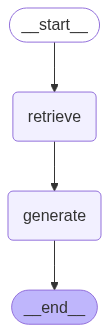

In [27]:
graph

Let's take it for a spin!

We invoke our graph like we do any other Runnable in LCEL!

> NOTE: That's right, even a compiled graph is a Runnable!

In [30]:
from IPython.display import Markdown, display
response = graph.invoke({"question" : "Is applying for and securing a student loan in 2025 a terrible idea?"})
display(Markdown(response["response"]))

Based on the provided context, applying for and securing a student loan in 2025 is not indicated as a terrible idea. The documents detail procedures, deadlines, and eligibility considerations for student aid programs, such as loan limits, counseling requirements, and application deadlines, but do not suggest that taking out a student loan in 2025 is inherently a bad decision.

In [29]:
response = graph.invoke({"question" : "How much loan money can I actually get from the government to go to school these days? Is there a cap?"})
display(Markdown(response["response"]))

Based on the provided context, the maximum loan amount a student may receive from the government depends on the type of program and the student's enrollment status. 

For a dependent student enrolled in a 900 clock-hour program, the prorated combined subsidized and unsubsidized annual loan limit is approximately $4,583, with no more than $2,917 of that amount being subsidized. If the student receives the maximum during the program, there may be no remaining loan eligibility afterward.

For a first-year dependent undergraduate, the full annual combined loan limit is $5,500, with up to $3,500 of that being subsidized, and this can be disbursed in two equal payments.

There are also aggregate loan limits for different categories, such as $31,000 for dependent undergraduates and $57,500 for independent undergraduates, which cap the total outstanding loan debt a student can have from federal loans.

In summary: Yes, there is a cap on the amount of federal student loan money a student can receive, which varies depending on the program and student status. The limits are specified per academic year and also have an overall maximum for each student.

In [31]:
response = graph.invoke({"question" : "What grants and scholarships are available for free?"})
display(Markdown(response["response"]))

Based on the provided context, the grants and scholarships available for free include Pell Grants, FSEOG (Federal Supplemental Educational Opportunity Grants), state grants, and scholarships that do not require future employment or other conditions.

In [32]:
response = graph.invoke({"question" : "Who is Batman?"})
display(Markdown(response["response"]))

I don't know

#### ❓ Question #2:
LangGraph's graph-based approach lets us visualize and manage complex flows naturally. How could we extend our current implementation to handle edge cases? For example:
- What if the retriever finds no relevant context?  
- What if the response needs fact-checking?
Consider how you would modify the graph to handle these scenarios.

##### ✅ Answer:

To handle these edge cases, we can extend our LangGraph implementation with conditional routing and additional nodes that evaluate context quality and perform fact-checking. Here's a comprehensive solution:

### 1. Enhanced State Structure

First, let's extend our state to track additional metadata for edge case handling:


In [33]:
from typing_extensions import TypedDict
from typing import Optional
from langchain_core.documents import Document

class EnhancedState(TypedDict):
    question: str
    context: list[Document]
    response: str
    context_quality: Optional[str]  # "sufficient", "insufficient", "none"
    fact_check_result: Optional[str]  # "verified", "questionable", "false"
    confidence_score: Optional[float]
    retry_count: int
    final_response: str


### 2. Enhanced Node Implementations

Now let's implement the new nodes for context evaluation and fact-checking:


In [34]:
def enhanced_retrieve(state: EnhancedState) -> EnhancedState:
    """Enhanced retrieve node with context tracking"""
    retrieved_docs = retriever.invoke(state["question"])
    return {
        "context": retrieved_docs,
        "retry_count": state.get("retry_count", 0)
    }

def evaluate_context(state: EnhancedState) -> EnhancedState:
    """Evaluate the quality and relevance of retrieved context"""
    context = state["context"]
    
    # Check if we have any documents
    if not context or len(context) == 0:
        return {"context_quality": "none"}
    
    # Use LLM to evaluate context relevance
    context_eval_prompt = ChatPromptTemplate.from_messages([
        ("human", """
        Question: {question}
        Retrieved Context: {context}
        
        Evaluate if the context is sufficient to answer the question.
        Respond with only one word:
        - "sufficient" if context can answer the question
        - "insufficient" if context is partially relevant but incomplete  
        - "none" if context is completely irrelevant
        """)
    ])
    
    evaluator_chain = context_eval_prompt | openai_chat_model | StrOutputParser()
    
    context_text = "\n\n".join([doc.page_content for doc in context])
    quality = evaluator_chain.invoke({
        "question": state["question"],
        "context": context_text
    }).strip().lower()
    
    return {"context_quality": quality}


In [35]:
def generate_fallback_response(state: EnhancedState) -> EnhancedState:
    """Generate response when context is insufficient"""
    fallback_prompt = ChatPromptTemplate.from_messages([
        ("human", """
        Question: {question}
        
        I don't have sufficient relevant information to answer this question accurately.
        Provide a helpful response that:
        1. Acknowledges the limitation
        2. Suggests where the user might find this information
        3. Offers any general guidance if appropriate
        """)
    ])
    
    fallback_chain = fallback_prompt | openai_chat_model | StrOutputParser()
    response = fallback_chain.invoke({"question": state["question"]})
    
    return {
        "response": response,
        "final_response": response,
        "confidence_score": 0.3
    }

def generate_with_context(state: EnhancedState) -> EnhancedState:
    """Generate response with sufficient context"""
    generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
    response = generator_chain.invoke({
        "query": state["question"], 
        "context": state["context"]
    })
    
    return {
        "response": response,
        "confidence_score": 0.8
    }


In [36]:
def fact_check_response(state: EnhancedState) -> EnhancedState:
    """Fact-check the generated response against retrieved context"""
    fact_check_prompt = ChatPromptTemplate.from_messages([
        ("human", """
        Original Question: {question}
        Retrieved Context: {context}
        Generated Response: {response}
        
        Evaluate if the response is factually accurate based on the context.
        Consider:
        1. Does the response contradict the source material?
        2. Does the response make claims not supported by the context?
        3. Are there any logical inconsistencies?
        
        Respond with only one word:
        - "verified" if response is factually accurate
        - "questionable" if there are minor issues or uncertainties
        - "false" if response contains significant factual errors
        """)
    ])
    
    fact_checker_chain = fact_check_prompt | openai_chat_model | StrOutputParser()
    
    context_text = "\n\n".join([doc.page_content for doc in state["context"]])
    result = fact_checker_chain.invoke({
        "question": state["question"],
        "context": context_text,
        "response": state["response"]
    }).strip().lower()
    
    return {"fact_check_result": result}

def revise_response(state: EnhancedState) -> EnhancedState:
    """Revise response if fact-check fails"""
    revision_prompt = ChatPromptTemplate.from_messages([
        ("human", """
        Question: {question}
        Context: {context}
        Previous Response: {previous_response}
        
        The previous response had factual issues. Generate a corrected response that:
        1. Strictly adheres to the provided context
        2. Acknowledges uncertainty where appropriate
        3. Avoids making unsupported claims
        """)
    ])
    
    revision_chain = revision_prompt | openai_chat_model | StrOutputParser()
    
    context_text = "\n\n".join([doc.page_content for doc in state["context"]])
    revised_response = revision_chain.invoke({
        "question": state["question"],
        "context": context_text,
        "previous_response": state["response"]
    })
    
    return {
        "final_response": revised_response,
        "confidence_score": 0.7
    }

def finalize_response(state: EnhancedState) -> EnhancedState:
    """Finalize verified response"""
    return {
        "final_response": state["response"],
        "confidence_score": state.get("confidence_score", 0.9)
    }


### 3. Conditional Routing Functions

These functions determine which node to execute next based on the current state:


In [37]:
def route_after_context_eval(state: EnhancedState) -> str:
    """Route based on context quality"""
    quality = state.get("context_quality", "none")
    
    if quality == "sufficient":
        return "generate_with_context"
    elif quality == "insufficient" and state.get("retry_count", 0) < 2:
        return "retry_retrieval"  # Could implement enhanced retrieval
    else:
        return "generate_fallback"

def route_after_fact_check(state: EnhancedState) -> str:
    """Route based on fact-check results"""
    result = state.get("fact_check_result", "verified")
    
    if result == "verified":
        return "finalize_response"
    elif result in ["questionable", "false"]:
        return "revise_response"
    else:
        return "finalize_response"


### 4. Enhanced Graph Construction

Now let's build the enhanced graph with conditional routing and edge case handling:


In [38]:
from langgraph.graph import StateGraph, START, END

def build_enhanced_rag_graph():
    # Create the graph builder
    graph_builder = StateGraph(EnhancedState)
    
    # Add all nodes
    graph_builder.add_node("enhanced_retrieve", enhanced_retrieve)
    graph_builder.add_node("evaluate_context", evaluate_context)
    graph_builder.add_node("generate_with_context", generate_with_context)
    graph_builder.add_node("generate_fallback", generate_fallback_response)
    graph_builder.add_node("fact_check", fact_check_response)
    graph_builder.add_node("revise_response", revise_response)
    graph_builder.add_node("finalize_response", finalize_response)
    
    # Define the flow
    graph_builder.add_edge(START, "enhanced_retrieve")
    graph_builder.add_edge("enhanced_retrieve", "evaluate_context")
    
    # Conditional routing after context evaluation
    graph_builder.add_conditional_edges(
        "evaluate_context",
        route_after_context_eval,
        {
            "generate_with_context": "generate_with_context",
            "generate_fallback": "generate_fallback",
            "retry_retrieval": "enhanced_retrieve"  # Loop back for retry
        }
    )
    
    # Route to fact-checking or direct finish
    graph_builder.add_edge("generate_with_context", "fact_check")
    graph_builder.add_edge("generate_fallback", END)
    
    # Conditional routing after fact check
    graph_builder.add_conditional_edges(
        "fact_check",
        route_after_fact_check,
        {
            "finalize_response": "finalize_response",
            "revise_response": "revise_response"
        }
    )
    
    # Final edges
    graph_builder.add_edge("revise_response", "finalize_response")
    graph_builder.add_edge("finalize_response", END)
    
    return graph_builder.compile()

# Build the enhanced graph
enhanced_rag_graph = build_enhanced_rag_graph()


### 5. Visualize the Enhanced Graph


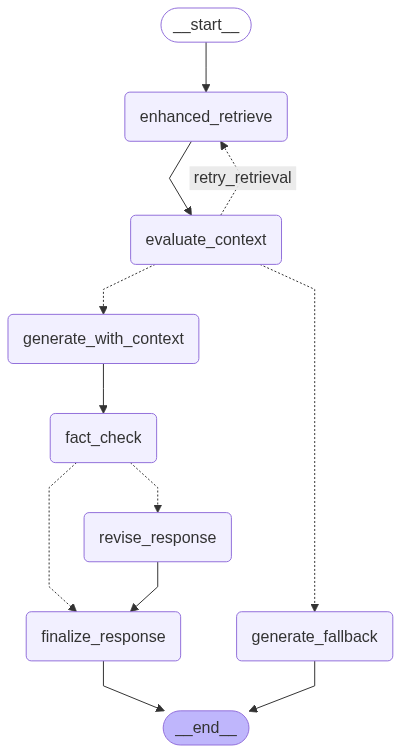

In [39]:
# Let's visualize our enhanced graph
enhanced_rag_graph


### 6. Testing the Enhanced RAG System

Let's test our enhanced system with different scenarios:


In [40]:
# Test case 1: Normal query with good context
print("=== Test 1: Query with relevant context ===")
result1 = enhanced_rag_graph.invoke({
    "question": "What is the maximum loan amount for undergraduates?",
    "retry_count": 0
})

print(f"Final Response: {result1.get('final_response', 'N/A')}")
print(f"Confidence Score: {result1.get('confidence_score', 'N/A')}")
print(f"Context Quality: {result1.get('context_quality', 'N/A')}")
print(f"Fact Check Result: {result1.get('fact_check_result', 'N/A')}")
print("\\n" + "="*50 + "\\n")


=== Test 1: Query with relevant context ===
Final Response: The maximum loan amount for undergraduates varies based on their dependency status and year of study. 

- For dependent undergraduates (excluding those whose parents cannot get Direct PLUS Loans), the annual loan limits are:
  - First Year: up to $5,500 (with no more than $3,500 subsidized)
  - Second Year: up to $6,500 (with no more than $4,500 subsidized)
  - Third Year and Beyond: up to $7,500 (with no more than $5,500 subsidized)

- For independent undergraduates (and dependent undergraduates whose parents cannot get Direct PLUS Loans), the annual loan limits are higher:
  - First Year: up to $9,500 (with no more than $3,500 subsidized)
  
These limits are for a single academic year and may be prorated if enrolled in a program shorter than a full academic year.
Confidence Score: 0.8
Context Quality: sufficient
Fact Check Result: verified
\n==================================================\n


In [41]:
# Test case 2: Query unlikely to have relevant context
print("=== Test 2: Query with poor/no relevant context ===")
result2 = enhanced_rag_graph.invoke({
    "question": "What is the capital of Mars?",
    "retry_count": 0
})

print(f"Final Response: {result2.get('final_response', 'N/A')}")
print(f"Confidence Score: {result2.get('confidence_score', 'N/A')}")
print(f"Context Quality: {result2.get('context_quality', 'N/A')}")
print(f"Fact Check Result: {result2.get('fact_check_result', 'N/A')}")
print("\\n" + "="*50 + "\\n")


=== Test 2: Query with poor/no relevant context ===
Final Response: I'm sorry, but I don't have sufficient information to determine the capital of Mars. Currently, Mars is a planet without any established cities or governance, so it doesn't have a capital. If you're interested in information about human settlements or future colonization plans on Mars, you might explore resources related to space agencies like NASA or private companies such as SpaceX. They often publish updates on missions and potential habitats being developed for future exploration.
Confidence Score: 0.3
Context Quality: none
Fact Check Result: N/A
\n==================================================\n


### Key Enhancements Implemented

Our enhanced LangGraph RAG system now includes:

1. **Context Quality Assessment**: Automatically evaluates whether retrieved context is sufficient to answer the question
2. **Fallback Handling**: Graceful degradation when context is insufficient 
3. **Fact-Checking**: Validates responses against source material to ensure accuracy
4. **Response Revision**: Corrects factually incorrect responses automatically
5. **Confidence Tracking**: Provides confidence scores for transparency
6. **Retry Logic**: Allows for retrieval retries with enhanced strategies

### Enhanced Flow Architecture

The enhanced graph handles multiple pathways:

```
START → enhanced_retrieve → evaluate_context
                               ↓
        ┌─── insufficient ←──┤
        ↓                   ↓ sufficient
generate_fallback    generate_with_context
        ↓                   ↓
       END              fact_check
                           ↓
                ┌── false/questionable
                ↓          ↓ verified
        revise_response → finalize_response
                           ↓
                          END
```

This architecture makes the RAG system much more robust by handling edge cases gracefully and ensuring response quality through validation and fact-checking mechanisms.
